# Working on Time Series Prediction for Renewable Energy

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [264]:
# Original Datasets
weather = pd.read_csv("/Users/anastasiakurakova/Desktop/BDA 602 project/Spain Weather/weather_features_collapsed.csv")
energy = pd.read_csv("/Users/anastasiakurakova/Desktop/BDA 602 project/Spain Weather/energy_dataset.csv")

#### For this time series analysis we are working with energy dataset only. Next we need to do data preprocessing. Transform time to the DateTime format. Impute Missing Values and Remove Empty/Irrelevant Columns

In [265]:
# Dropped time column and empty columns
new_energy = energy.drop(columns=['time','generation fossil coal-derived gas','generation fossil oil shale','generation fossil peat','generation geothermal','generation hydro pumped storage aggregated','generation marine','generation wind offshore','forecast wind offshore eday ahead'])
new_energy.head()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,17.0,6436.0,26118.0,25385.0,50.10,65.41
1,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,16.0,5856.0,24934.0,24382.0,48.10,64.92
2,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,8.0,5454.0,23515.0,22734.0,47.33,64.48
3,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,2.0,5151.0,22642.0,21286.0,42.27,59.32
4,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,9.0,4861.0,21785.0,20264.0,38.41,56.04


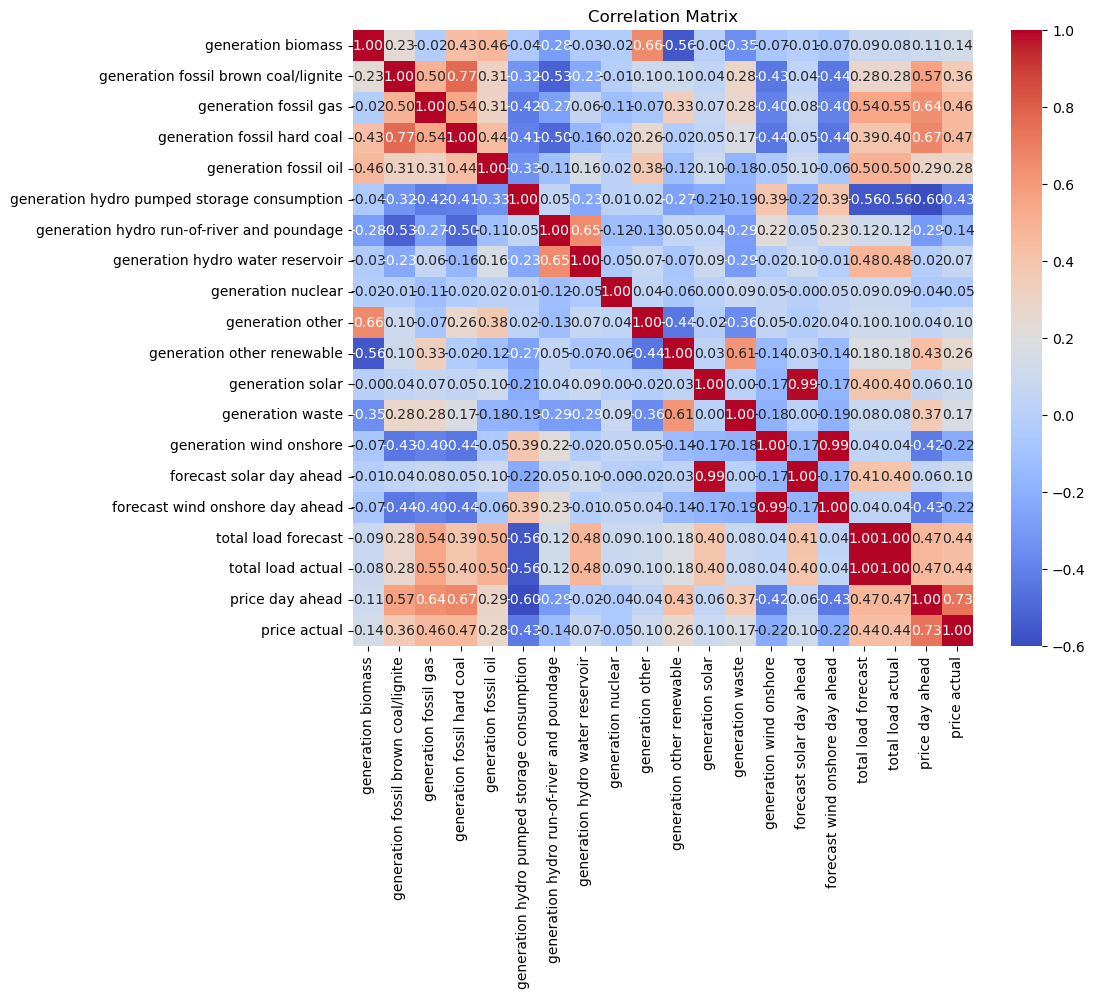

In [173]:
# As part of EDA we examine Heatmap Correlation Matrix
corr_matrix = new_energy.corr()
# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

### Analysis of heatmap demonstrates that renewable energy is negatively correlated with price, which means that the more energy is generated using renewable sources, the lower energy price is going to be. At the same time we see positive correlation between fossil energy and the price. This also emphasises the importance of switching to the renewable sources. 

In [266]:
### Next we have to check for missing values and impute.
new_energy.isna().sum()

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
forecast solar day ahead                        0
forecast wind onshore day ahead                 0
total load forecast                             0
total load actual                              36
price day ahead                                 0
price actual                                    0


In [267]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
# now to use Iterative imputer
imputer = IterativeImputer(max_iter=10, random_state=0)
imputer.fit(new_energy)
new_energy_nona = pd.DataFrame(imputer.transform(new_energy), columns = new_energy.columns, index=new_energy.index)

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [268]:
new_energy_nona.isna().sum()

generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind onshore                        0
forecast solar day ahead                       0
forecast wind onshore day ahead                0
total load forecast                            0
total load actual                              0
price day ahead                                0
price actual                                   0
dtype: int64

## Now we add time column back and convert it to the DateTime

In [269]:
# Insert the time column at the first position
new_energy_nona.insert(0, 'time', energy['time'])
new_energy_nona.head()
# Transforming time to a different format
new_energy_nona['time'] = pd.to_datetime(new_energy_nona['time'],utc='True',errors='coerce')
new_energy_nona['time'] = new_energy_nona['time'].dt.tz_localize(None)
new_energy_nona.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2014-12-31 23:00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,73.0,49.0,196.0,6378.0,17.0,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 00:00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,71.0,50.0,195.0,5890.0,16.0,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 01:00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,73.0,50.0,196.0,5461.0,8.0,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 02:00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,75.0,50.0,191.0,5238.0,2.0,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 03:00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,74.0,42.0,189.0,4935.0,9.0,4861.0,21785.0,20264.0,38.41,56.04


In [10]:
new_energy_nona.to_csv('energy_modified.csv',index=False)

### Next we are looking at the columns

In [270]:
df=new_energy_nona
df.columns

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil gas', 'generation fossil hard coal',
       'generation fossil oil', 'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation nuclear',
       'generation other', 'generation other renewable', 'generation solar',
       'generation waste', 'generation wind onshore',
       'forecast solar day ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual'],
      dtype='object')

In [271]:
# Renewable Energy Columns
renewable_columns = ['generation biomass',
 'generation hydro run-of-river and poundage',
 #'generation hydro pumped storage consumption', 
 #- we decided not to include this column in prediction due to ambiguity (didn't find information whether it is generation or consumption).
 'generation hydro water reservoir',
 'generation other renewable',
 'generation solar',
 'generation waste',
 'generation wind onshore']

In [272]:
# Non Renewable Energy Columns
nonrenewable_columns = ['generation fossil brown coal/lignite',
                        'generation fossil gas',
                        'generation fossil hard coal',
                        'generation fossil oil',
                        'generation nuclear',
                        'generation other']

In [273]:
df.describe()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,...,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35064,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,...,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,2016-12-31 10:30:00,383.519737,448.045933,5622.776001,4256.065929,298.324289,475.557609,972.137971,2605.242524,6263.873731,...,85.639479,1432.944288,269.446732,5465.024155,1439.066735,5471.216689,28712.129962,28697.832213,49.874341,57.884023
min,2014-12-31 23:00:00,0.000000,-21.064563,0.000000,0.000000,0.000000,-873.523569,0.000000,0.000000,0.000000,...,0.000000,-8.231253,0.000000,0.000000,0.000000,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,2016-01-01 04:45:00,333.000000,0.000000,4126.000000,2527.000000,263.000000,0.000000,637.000000,1077.000000,5761.000000,...,74.000000,71.000000,240.000000,2933.000000,69.000000,2979.000000,24793.750000,24807.000000,41.490000,49.347500
50%,2016-12-31 10:30:00,367.000000,509.000000,4969.500000,4475.000000,300.000000,68.000000,906.000000,2164.500000,6563.500000,...,88.000000,616.000000,279.000000,4849.500000,576.000000,4855.000000,28906.000000,28902.500000,50.520000,58.020000
75%,2017-12-31 16:15:00,433.000000,757.000000,6430.000000,5839.000000,330.000000,616.000000,1250.000000,3757.250000,7024.000000,...,97.000000,2579.000000,310.000000,7399.500000,2636.000000,7353.000000,32263.250000,32193.000000,60.530000,68.010000
max,2018-12-31 22:00:00,592.000000,999.000000,20034.000000,8359.000000,449.000000,4523.000000,2000.000000,9728.000000,7117.000000,...,119.000000,5792.000000,357.000000,17436.000000,5836.000000,17430.000000,41390.000000,41015.000000,101.990000,116.800000
std,NaN,85.332125,354.560680,2202.384984,1961.779689,52.519602,792.485107,400.676116,1835.174803,839.476537,...,14.074728,1680.157081,50.185038,3213.618915,1677.703355,3176.312853,4594.100854,4575.842987,14.618900,14.204083


Text(0.5, 1.0, 'Renewable Energy Generated by Different Sources (MW)')

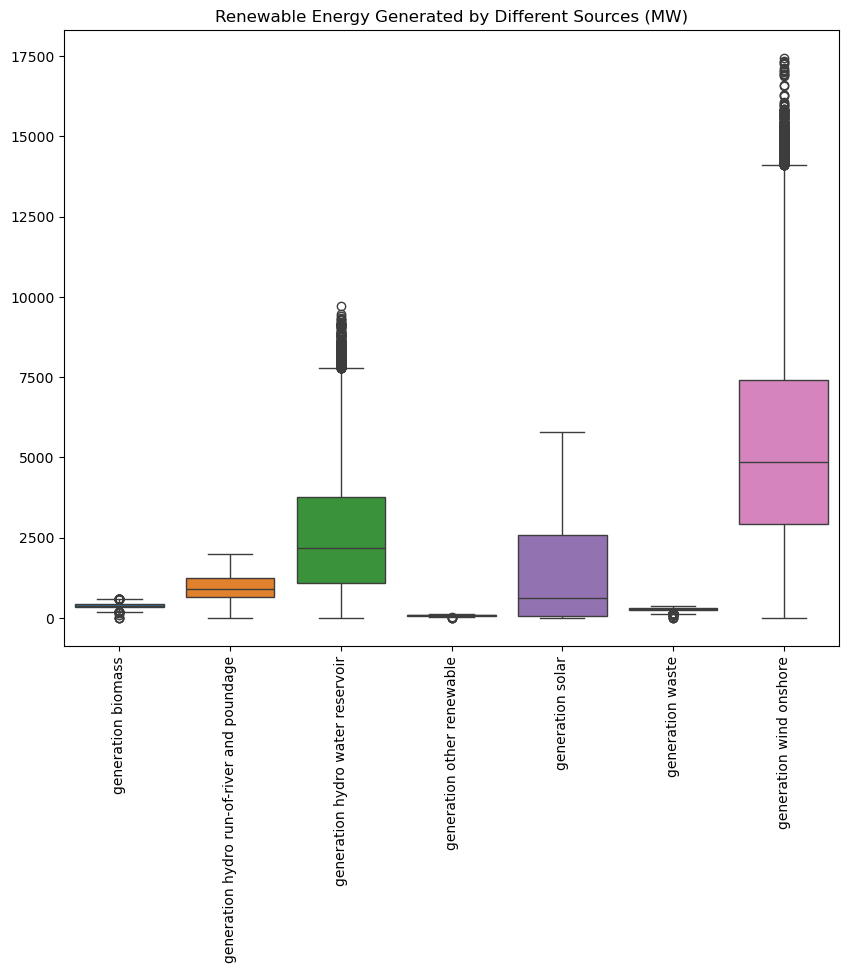

In [274]:
# Visualizing Renewable Energy Sources
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=new_energy_nona[renewable_columns])
plt.xticks(rotation=90)
ax.set_title('Renewable Energy Generated by Different Sources (MW)')

#### Majority of Renewable Energy Comes From Wind Onshore Sources. Next Are Hydro Generation Sources

In [275]:
# Total non renewable and renewable energy generated
df['total_renewable_energy'] = df[renewable_columns].sum(axis=1)
df['total_nonrenewable_energy'] = df[nonrenewable_columns].sum(axis=1)

In [276]:
#Resampling to smooth out the graphs
monthly_data = df.resample('M', on='time').mean()

### Visualizing monthly energy generation from renewable and non renewable sources

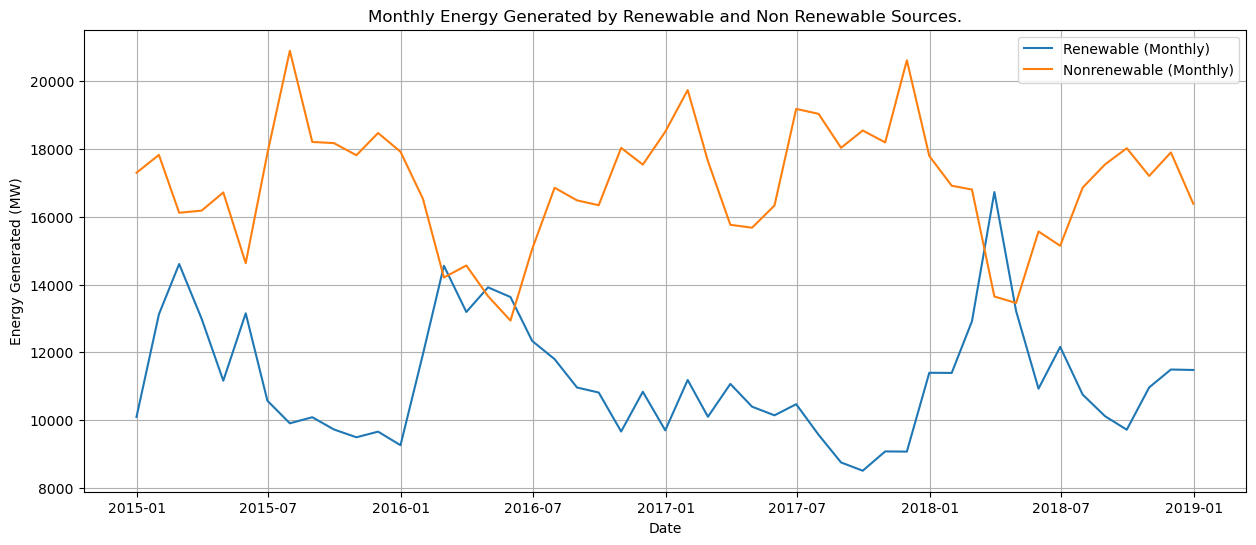

In [277]:
plt.figure(figsize=(15, 6))
plt.plot(monthly_data.index, monthly_data['total_renewable_energy'], label='Renewable (Monthly)')
plt.plot(monthly_data.index, monthly_data['total_nonrenewable_energy'], label='Nonrenewable (Monthly)')
plt.xlabel('Date')
plt.ylabel('Energy Generated (MW)')
plt.title('Monthly Energy Generated by Renewable and Non Renewable Sources.')
plt.legend()
plt.grid(True)
plt.show()

### It looks like we have a seasonal pattern where during the spring months a good proportion of total energy is generated using renewable energy sources. and during the fall/winter when the country mostly relies on non renewable sources.

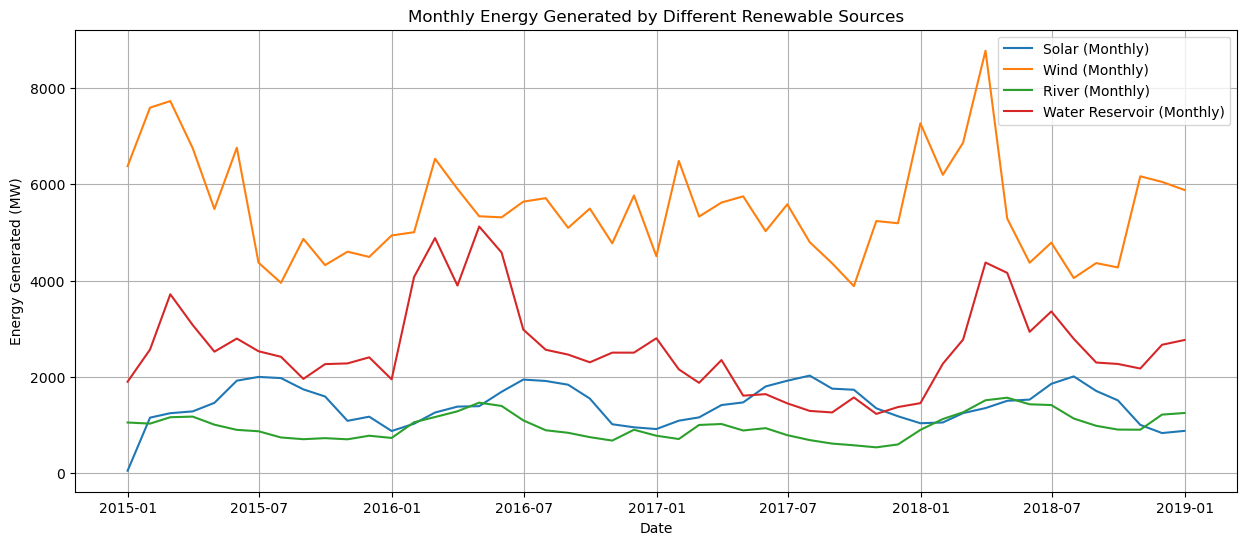

In [278]:
plt.figure(figsize=(15, 6))
plt.plot(monthly_data.index, monthly_data['generation solar'], label='Solar (Monthly)')
plt.plot(monthly_data.index, monthly_data['generation wind onshore'], label='Wind (Monthly)')
plt.plot(monthly_data.index, monthly_data['generation hydro run-of-river and poundage'], label='River (Monthly)')
plt.plot(monthly_data.index, monthly_data['generation hydro water reservoir'], label='Water Reservoir (Monthly)')
plt.xlabel('Date')
plt.ylabel('Energy Generated (MW)')
plt.title('Monthly Energy Generated by Different Renewable Sources')
plt.legend()
plt.grid(True)
plt.show()

### This Graph demonstrates that most of the renewable energy comes from Wind Turbines and Water Reservoir. Both demonstrate an increased amount of energy generated in spring months and Lower generation in summer and fall. Solar Energy generation, on the other hand increases in summer. 

# Using XGBoost Regressor for Time Series Prediction

In [301]:
df1 = df[['time','total_renewable_energy']].copy()
df1 = df1.set_index('time')
df1.head()

,total_renewable_energy
time,
2014-12-31 23:00:00,10093.0
2015-01-01 00:00:00,9322.0
2015-01-01 01:00:00,8572.0
2015-01-01 02:00:00,7720.0
2015-01-01 03:00:00,7341.0


In [303]:
# Train/ Test split
#replaced df1 with monthly data to see if it gets better
train = df1.loc[df1.index < '2018-05-01']
test = df1.loc[df1.index >= '2018-05-01']

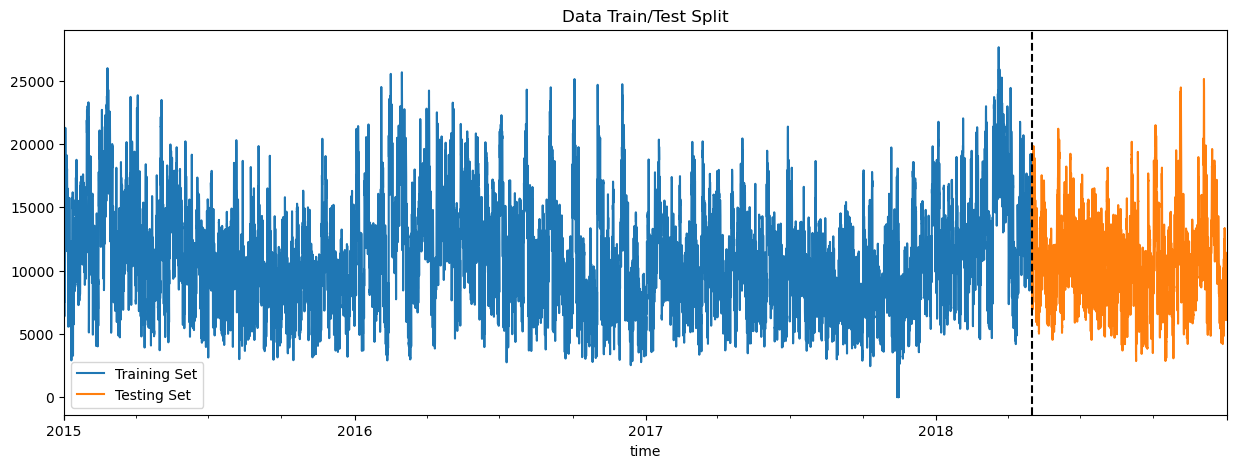

In [304]:
fig, ax = plt.subplots(figsize= (15,5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Testing Set')
ax.axvline('2018-05-01',color='black',ls='--')
ax.legend(['Training Set','Testing Set'])
plt.show()

<Axes: xlabel='time'>

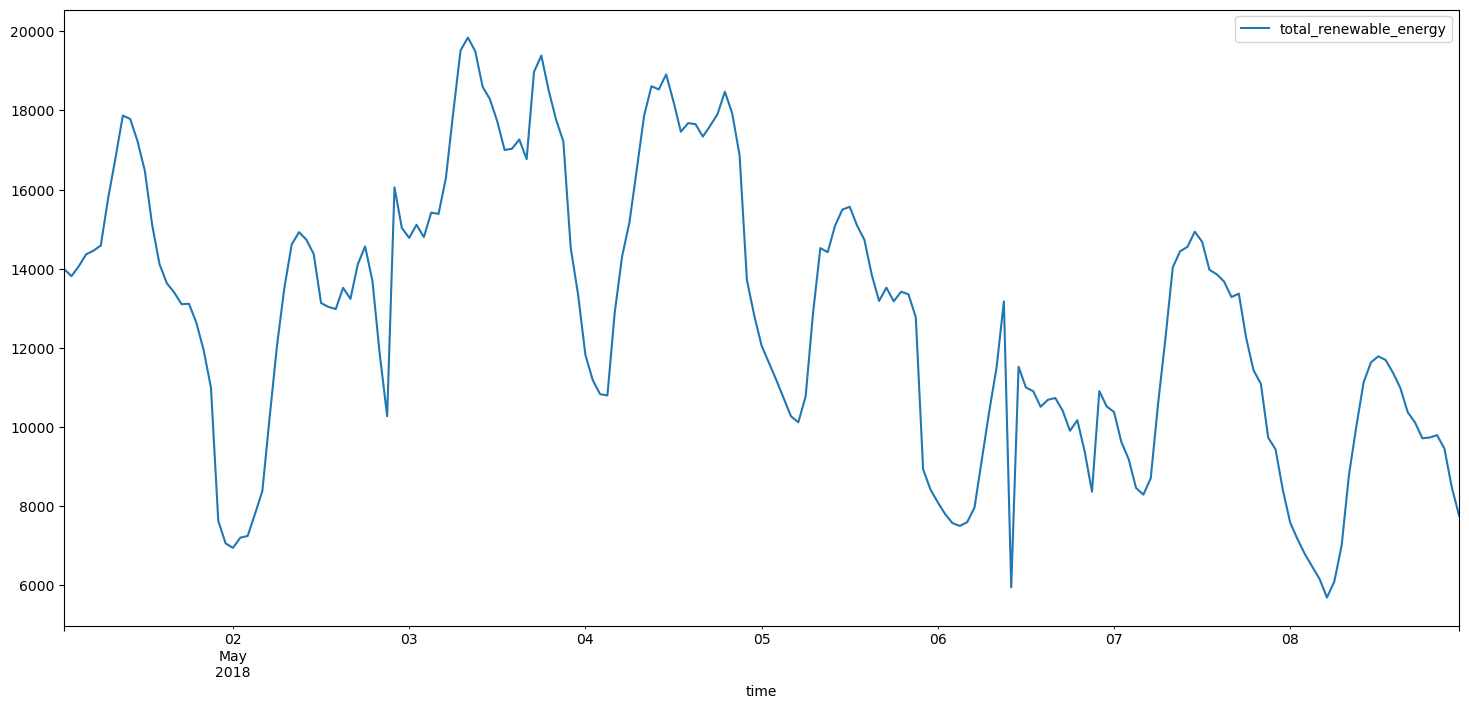

In [305]:
df1.loc[(df1.index > '2018-05-01') & (df1.index < '2018-05-09')].plot()

In [306]:
# Creating Features From Time Column
def create_features(df):
    """
    Creating features
    """
    df=df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df
df1 = create_features(df1)

Text(0.5, 1.0, 'Total Renewable Energy Generated (MW) per month')

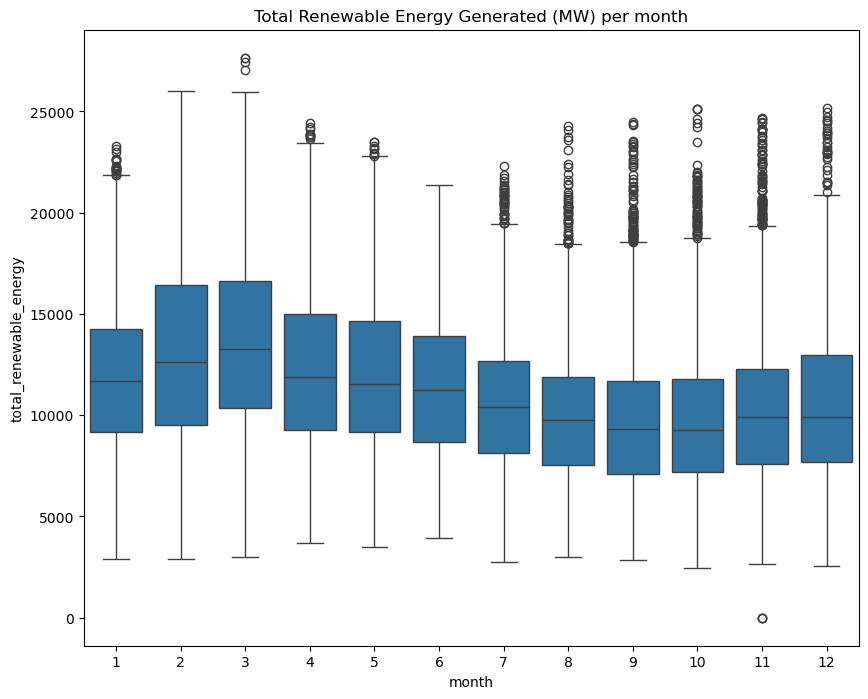

In [307]:
# Visualize feature to target variable
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df1,x='month',y='total_renewable_energy')
ax.set_title('Total Renewable Energy Generated (MW) per month')

### We can observe an increased renewable energy generation in February and March and the decreased energy generation in Fall.

In [308]:
train = create_features(train)
test = create_features(test)
features = ['hour', 'dayofweek', 'quarter', 'month',
       'year', 'dayofyear']
target = 'total_renewable_energy'
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [309]:
# Training XGBoost Regressor Model
reg = xgb.XGBRegressor(n_estimators= 1000,early_stopping_rounds= 50,learning_rate=0.01)
reg.fit(X_train,y_train,
        eval_set=[(X_train,y_train),(X_test,y_test)],
        verbose= True)

[0]	validation_0-rmse:4160.69630	validation_1-rmse:3508.09702
[1]	validation_0-rmse:4144.23585	validation_1-rmse:3494.67000
[2]	validation_0-rmse:4128.03578	validation_1-rmse:3481.60421
[3]	validation_0-rmse:4112.01688	validation_1-rmse:3468.78947
[4]	validation_0-rmse:4096.10798	validation_1-rmse:3457.91683
[5]	validation_0-rmse:4080.40406	validation_1-rmse:3447.69782
[6]	validation_0-rmse:4065.19018	validation_1-rmse:3435.83557
[7]	validation_0-rmse:4050.00694	validation_1-rmse:3425.79020
[8]	validation_0-rmse:4035.07734	validation_1-rmse:3415.53130
[9]	validation_0-rmse:4021.14918	validation_1-rmse:3404.46765
[10]	validation_0-rmse:4006.66552	validation_1-rmse:3395.75529
[11]	validation_0-rmse:3993.09304	validation_1-rmse:3385.31293
[12]	validation_0-rmse:3979.17503	validation_1-rmse:3375.05996
[13]	validation_0-rmse:3965.38390	validation_1-rmse:3366.56256
[14]	validation_0-rmse:3951.56306	validation_1-rmse:3358.07568
[15]	validation_0-rmse:3938.87612	validation_1-rmse:3348.76440
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature Importance'}>

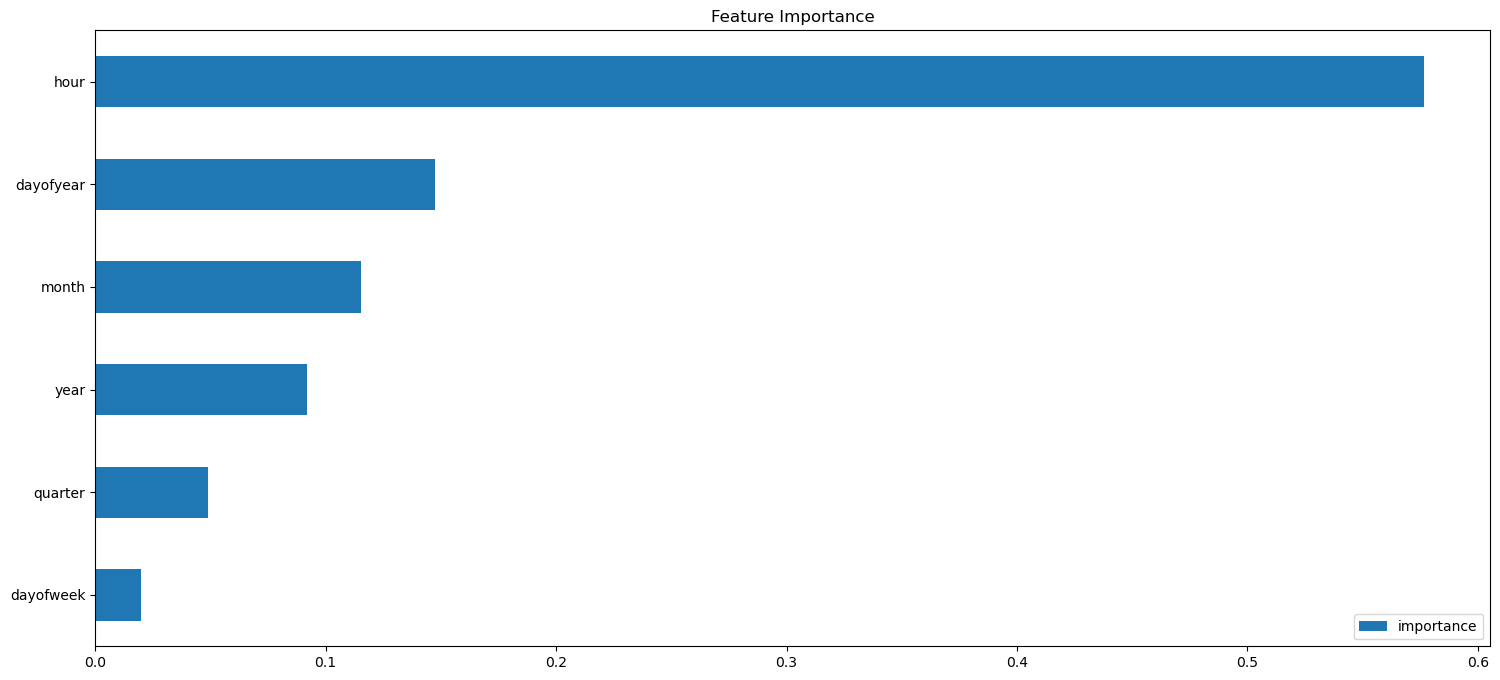

In [310]:
# Looking at the feature importance
fi = pd.DataFrame(data=reg.feature_importances_,
             index= reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh',title='Feature Importance')

#### Hour seems to be the most important feature affecting renewable energy generation. 

In [311]:
# Forecast on Test
test['prediction'] = reg.predict(X_test)
df1 = df1.merge(test[['prediction']], how='left', left_index=True,right_index=True)

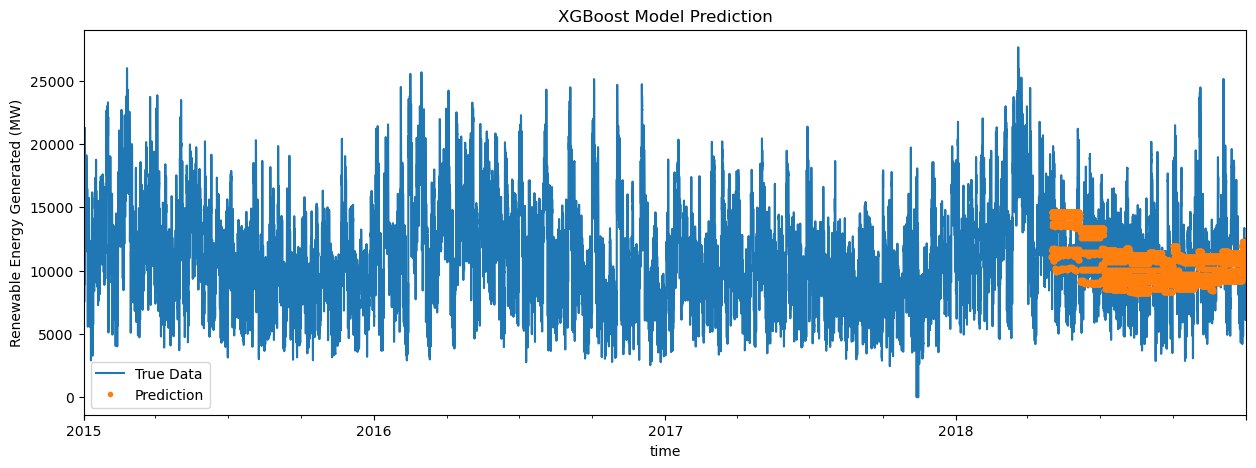

In [312]:
ax = df1[['total_renewable_energy']].plot(figsize=(15,5))
df1[['prediction']].plot(ax=ax, style='.')
plt.legend(['True Data','Prediction'])
ax.set_title('XGBoost Model Prediction')
ax.set_ylabel('Renewable Energy Generated (MW)')
plt.show()

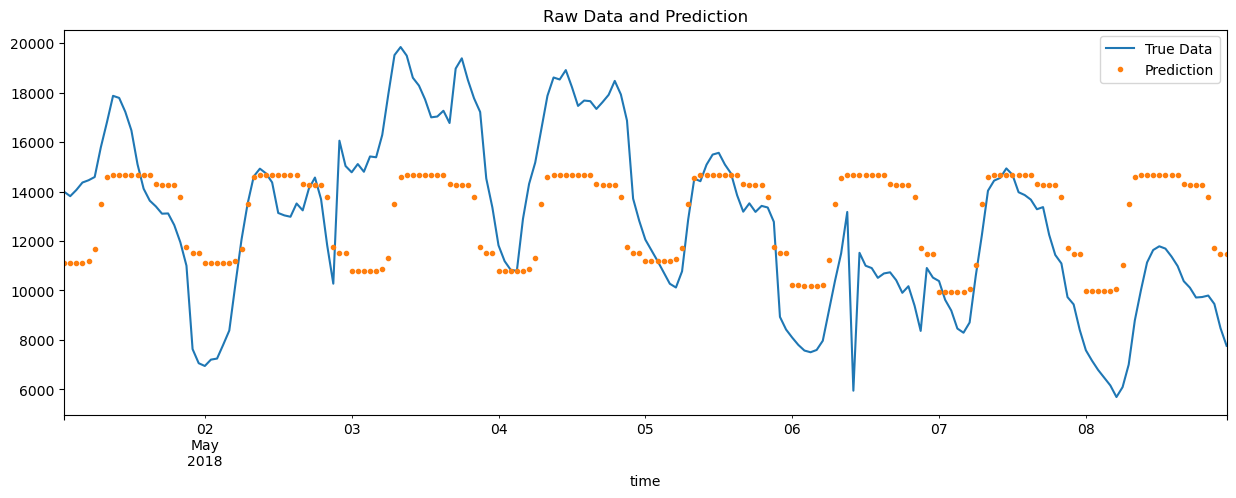

In [313]:
# Looking at the week of test data to see how well the prediction represent raw data.
ax = df1.loc[(df1.index > '2018-05-01') & (df1.index < '2018-05-09')]['total_renewable_energy'].plot(figsize=(15,5))
df1.loc[(df1.index > '2018-05-01') & (df1.index < '2018-05-09')]['prediction'].plot(ax=ax, style='.')
plt.legend(['True Data','Prediction'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [314]:
# Evaluating Model Performance using sklearn metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(test['total_renewable_energy'],test['prediction']))
mae = mean_absolute_error(test['total_renewable_energy'],test['prediction'])
r2 = r2_score(test['total_renewable_energy'],test['prediction'])
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2-score: {r2}')

RMSE: 3095.475544733542
MAE: 2382.751996157292
R2-score: 0.22117597578697423


In [239]:
# Using Mean Absolute Percentage Error.
def mean_absolute_percentage_error(y_true,y_pred):
    y_true, y_pred= np.array(y_true),np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100
mape = mean_absolute_percentage_error(test['total_renewable_energy'],test['prediction'])
mape

24.07633435785362

In [97]:
# Looking at the error range
test['error']= np.abs(test[target]-test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values()

date
2018-05-17      518.163045
2018-06-23      556.984049
2018-12-29      630.230143
2018-09-06      654.881673
2018-09-12      728.923625
                  ...     
2018-10-04     6734.922363
2018-10-03     8851.297363
2018-11-03     9843.523234
2018-11-04    10069.929728
2018-12-03    10114.956543
Name: error, Length: 245, dtype: float64

In [317]:
# Predicting into the future
features = ['hour', 'dayofweek', 'quarter', 'month',
       'year', 'dayofyear']
target = 'total_renewable_energy'
df1.head()


,total_renewable_energy,hour,dayofweek,quarter,month,year,dayofyear,prediction
time,,,,,,,,
2014-12-31 23:00:00,10093.0,23,2,4,12,2014,365,NaN
2015-01-01 00:00:00,9322.0,0,3,1,1,2015,1,NaN
2015-01-01 01:00:00,8572.0,1,3,1,1,2015,1,NaN
2015-01-01 02:00:00,7720.0,2,3,1,1,2015,1,NaN
2015-01-01 03:00:00,7341.0,3,3,1,1,2015,1,NaN


In [320]:
X_all=df1[features]
y_all=df1[target]
reg = xgb.XGBRegressor(n_estimators= 1000,early_stopping_rounds= 50,learning_rate=0.01)
reg.fit(X_all,y_all,
        eval_set=[(X_all,y_all)],
        verbose= True)

[0]	validation_0-rmse:4059.55623
[1]	validation_0-rmse:4044.82136
[2]	validation_0-rmse:4030.74832
[3]	validation_0-rmse:4016.90189
[4]	validation_0-rmse:4003.31965
[5]	validation_0-rmse:3989.94143
[6]	validation_0-rmse:3976.76460
[7]	validation_0-rmse:3963.74906
[8]	validation_0-rmse:3951.07266
[9]	validation_0-rmse:3938.61602
[10]	validation_0-rmse:3925.76025
[11]	validation_0-rmse:3913.33626
[12]	validation_0-rmse:3900.75969
[13]	validation_0-rmse:3888.29654


[14]	validation_0-rmse:3876.65700
[15]	validation_0-rmse:3864.55649
[16]	validation_0-rmse:3853.33301
[17]	validation_0-rmse:3841.62048
[18]	validation_0-rmse:3830.70733
[19]	validation_0-rmse:3819.40356
[20]	validation_0-rmse:3808.72018
[21]	validation_0-rmse:3797.88051
[22]	validation_0-rmse:3787.55058
[23]	validation_0-rmse:3776.83963
[24]	validation_0-rmse:3767.05839
[25]	validation_0-rmse:3756.60279
[26]	validation_0-rmse:3747.28685
[27]	validation_0-rmse:3737.37893
[28]	validation_0-rmse:3728.09330
[29]	validation_0-rmse:3718.48045
[30]	validation_0-rmse:3709.01580
[31]	validation_0-rmse:3699.30611
[32]	validation_0-rmse:3690.50802
[33]	validation_0-rmse:3681.88497
[34]	validation_0-rmse:3672.56468
[35]	validation_0-rmse:3663.45255
[36]	validation_0-rmse:3654.42297
[37]	validation_0-rmse:3645.00487
[38]	validation_0-rmse:3636.23534
[39]	validation_0-rmse:3627.49084
[40]	validation_0-rmse:3619.68425
[41]	validation_0-rmse:3611.06225
[42]	validation_0-rmse:3602.77526
[43]	validatio

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [321]:
df1.index.max()

Timestamp('2018-12-31 22:00:00')

In [327]:
future= pd.date_range(start='2018-12-31 22:00:00', end='2019-12-30',freq='1h')

In [333]:
future_df=pd.DataFrame(index=future)
future_df['isFuture']=True
df1['isFuture']=False
df_and_future = pd.concat([df1,future_df])
df_and_future=create_features(df_and_future)
df_and_future=df_and_future.drop(columns='prediction')
future_w_features = df_and_future.query('isFuture').copy()

In [334]:
future_w_features

,total_renewable_energy,hour,dayofweek,quarter,month,year,dayofyear,isFuture
2018-12-31 22:00:00,NaN,22,0,4,12,2018,365,True
2018-12-31 23:00:00,NaN,23,0,4,12,2018,365,True
2019-01-01 00:00:00,NaN,0,1,1,1,2019,1,True
2019-01-01 01:00:00,NaN,1,1,1,1,2019,1,True
2019-01-01 02:00:00,NaN,2,1,1,1,2019,1,True
...,...,...,...,...,...,...,...,...
2019-12-29 20:00:00,NaN,20,6,4,12,2019,363,True
2019-12-29 21:00:00,NaN,21,6,4,12,2019,363,True
2019-12-29 22:00:00,NaN,22,6,4,12,2019,363,True
2019-12-29 23:00:00,NaN,23,6,4,12,2019,363,True


In [335]:
future_w_features['pred'] = reg.predict(future_w_features[features])

<Axes: >

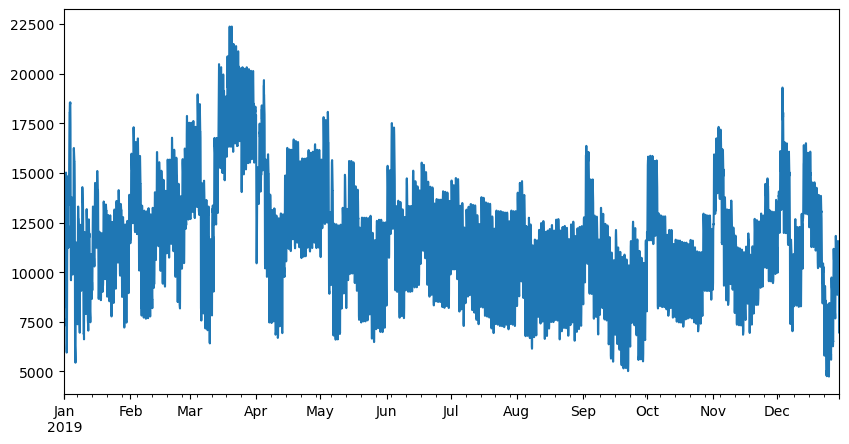

In [341]:

future_w_features['pred'].plot(figsize=(10,5))

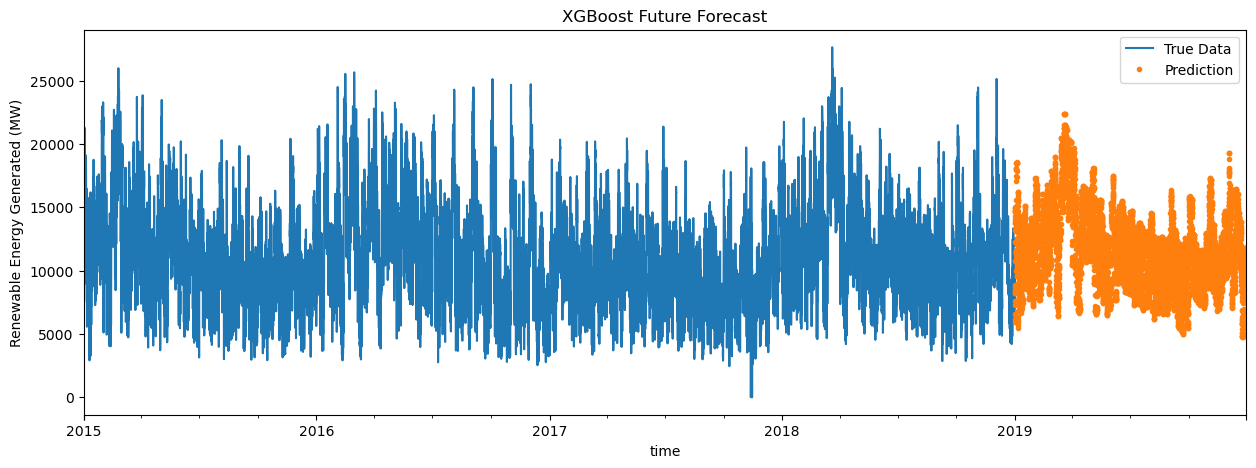

In [343]:
ax = df1[['total_renewable_energy']].plot(figsize=(15,5))
future_w_features[['pred']].plot(ax=ax, style='.')
plt.legend(['True Data','Prediction'])
ax.set_title('XGBoost Future Forecast')
ax.set_ylabel('Renewable Energy Generated (MW)')
plt.show()

## Second Model that we are using to attempt time series prediction is Prophet Model

In [98]:
df_prophet = df[['time','total_renewable_energy']].copy()
df_prophet.head()

,time,total_renewable_energy
0,2014-12-31 23:00:00,10093.0
1,2015-01-01 00:00:00,9322.0
2,2015-01-01 01:00:00,8572.0
3,2015-01-01 02:00:00,7720.0
4,2015-01-01 03:00:00,7341.0


In [99]:
df_prophet=df_prophet.rename(columns={'time':'ds','total_renewable_energy':'y'})
df_prophet.head()

,ds,y
0,2014-12-31 23:00:00,10093.0
1,2015-01-01 00:00:00,9322.0
2,2015-01-01 01:00:00,8572.0
3,2015-01-01 02:00:00,7720.0
4,2015-01-01 03:00:00,7341.0


In [100]:
# Training The Prophet Model
from prophet import Prophet
model = Prophet()
model.fit(df_prophet)

15:12:10 - cmdstanpy - INFO - Chain [1] start processing
15:12:16 - cmdstanpy - INFO - Chain [1] done processing


In [71]:
future_p = model.make_future_dataframe(periods=365)
future_p.tail()

,ds
35424,2019-12-27 22:00:00
35425,2019-12-28 22:00:00
35426,2019-12-29 22:00:00
35427,2019-12-30 22:00:00
35428,2019-12-31 22:00:00


In [101]:
forecast_p = model.predict(future_p)
forecast_p[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2014-12-31 23:00:00,9930.466433,5769.733797,14160.712119
1,2015-01-01 00:00:00,9509.943269,5247.004359,13530.797287
2,2015-01-01 01:00:00,9260.408746,5408.581218,13635.160810
3,2015-01-01 02:00:00,9076.994218,5085.213920,13459.551866
4,2015-01-01 03:00:00,8954.011285,4551.636308,12937.188035


/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


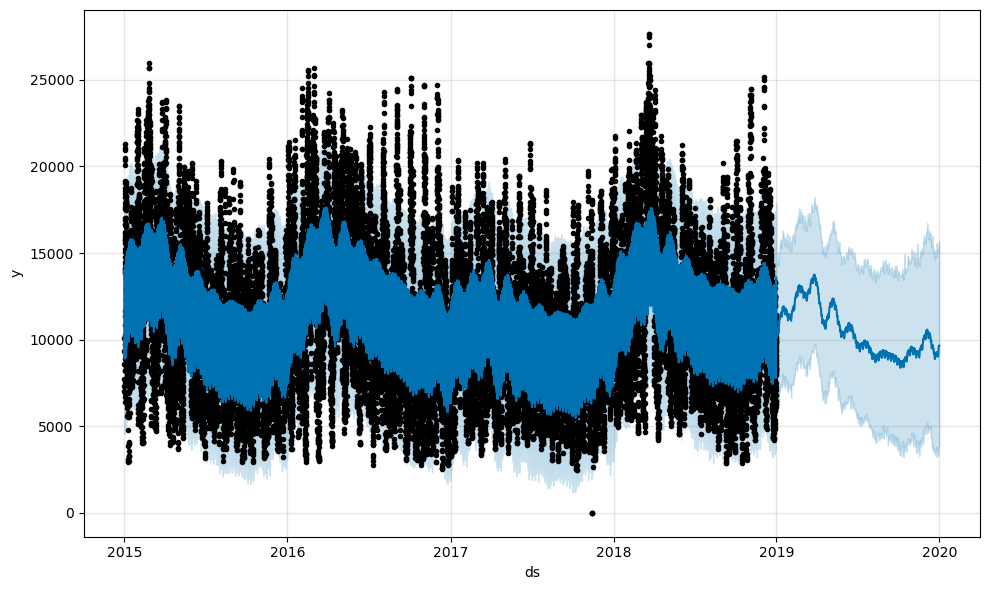

In [102]:
fig_p = model.plot(forecast_p)

### Our model predicts one year into the future.
#### Lets observe components of the prediction. Looking at the monthly/weekly/daily trends

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Serie

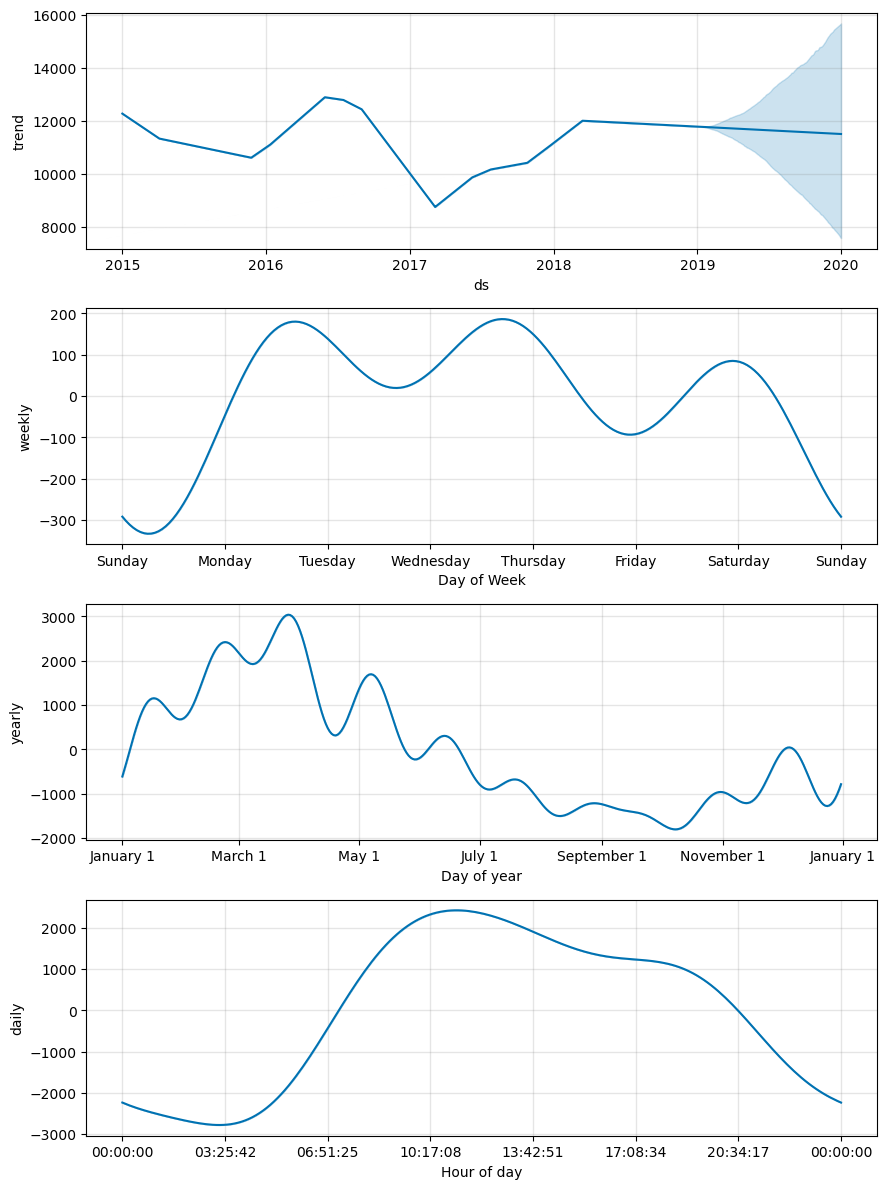

In [103]:
fig2_p = model.plot_components(forecast_p)

It looks like most of the renewable energy is generated during the day.

### Let's Evaluate Performance of our Prophet model

In [104]:
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Perform cross-validation
df_cv = cross_validation(model, initial='985 days', period='110 days', horizon='365 days')

# Calculate performance metrics
df_metrics = performance_metrics(df_cv)


# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(df_cv['y'], df_cv['yhat'])
mse = mean_squared_error(df_cv['y'], df_cv['yhat'])
rmse = np.sqrt(mse)
rsq = r2_score(df_cv['y'], df_cv['yhat'])


print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R-squared: {rsq:.2f}')


  0%|          | 0/2 [00:00<?, ?it/s]

15:12:44 - cmdstanpy - INFO - Chain [1] start processing
15:12:49 - cmdstanpy - INFO - Chain [1] done processing
15:12:52 - cmdstanpy - INFO - Chain [1] start processing
15:12:57 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 3394.44
Mean Squared Error: 17325292.15
Root Mean Squared Error: 4162.37
R-squared: -0.05


In [115]:
# Based on the Evaluation metrics our model doesn't perform well. We can perform Grid Search to fine tune the model. 


# Define the hyperparameter grid
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [1, 10, 30],
}


# Helper function to evaluate the model
def evaluate_model(model, metric_func):
    df_cv = cross_validation(model, initial='995 days', period='100 days', horizon='365 days')
    return metric_func(df_cv['y'], df_cv['yhat'])


# Grid search
best_params = {}
best_score = float('inf')

for mode in param_grid['seasonality_mode']:
    for cps in param_grid['changepoint_prior_scale']:
        for sps in param_grid['seasonality_prior_scale']:
            # Create a model with the current hyperparameters
            model = Prophet(seasonality_mode=mode, changepoint_prior_scale=cps, seasonality_prior_scale=sps)
            model.fit(df_prophet)

            # Evaluate the model using Mean Absolute Error (MAE)
            score = evaluate_model(model, mean_absolute_error)

            # Update best parameters if necessary
            if score < best_score:
                best_score = score
                best_params = {
                    'seasonality_mode': mode,
                    'changepoint_prior_scale': cps,
                    'seasonality_prior_scale': sps
                }

print(best_params)
print(best_score)

# Create the best model with the optimal hyperparameters
best_model = Prophet(**best_params)
best_model.fit(df_prophet)

15:49:57 - cmdstanpy - INFO - Chain [1] start processing
15:50:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

15:50:05 - cmdstanpy - INFO - Chain [1] start processing
15:50:08 - cmdstanpy - INFO - Chain [1] done processing
15:50:11 - cmdstanpy - INFO - Chain [1] start processing
15:50:13 - cmdstanpy - INFO - Chain [1] done processing
15:50:17 - cmdstanpy - INFO - Chain [1] start processing
15:50:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

15:50:22 - cmdstanpy - INFO - Chain [1] start processing
15:50:25 - cmdstanpy - INFO - Chain [1] done processing
15:50:29 - cmdstanpy - INFO - Chain [1] start processing
15:50:31 - cmdstanpy - INFO - Chain [1] done processing
15:50:34 - cmdstanpy - INFO - Chain [1] start processing
15:50:40 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

15:50:41 - cmdstanpy - INFO - Chain [1] start processing
15:50:43 - cmdstanpy - INFO - Chain [1] done processing
15:50:46 - cmdstanpy - INFO - Chain [1] start processing
15:50:49 - cmdstanpy - INFO - Chain [1] done processing
15:50:52 - cmdstanpy - INFO - Chain [1] start processing
15:51:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

15:51:04 - cmdstanpy - INFO - Chain [1] start processing
15:51:08 - cmdstanpy - INFO - Chain [1] done processing
15:51:11 - cmdstanpy - INFO - Chain [1] start processing
15:51:19 - cmdstanpy - INFO - Chain [1] done processing
15:51:23 - cmdstanpy - INFO - Chain [1] start processing
15:51:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

15:51:34 - cmdstanpy - INFO - Chain [1] start processing
15:51:39 - cmdstanpy - INFO - Chain [1] done processing
15:51:42 - cmdstanpy - INFO - Chain [1] start processing
15:51:50 - cmdstanpy - INFO - Chain [1] done processing
15:51:53 - cmdstanpy - INFO - Chain [1] start processing
15:52:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

15:52:02 - cmdstanpy - INFO - Chain [1] start processing
15:52:08 - cmdstanpy - INFO - Chain [1] done processing
15:52:11 - cmdstanpy - INFO - Chain [1] start processing
15:52:20 - cmdstanpy - INFO - Chain [1] done processing
15:52:24 - cmdstanpy - INFO - Chain [1] start processing
15:52:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

15:52:43 - cmdstanpy - INFO - Chain [1] start processing
15:52:50 - cmdstanpy - INFO - Chain [1] done processing
15:52:53 - cmdstanpy - INFO - Chain [1] start processing
15:53:09 - cmdstanpy - INFO - Chain [1] done processing
15:53:12 - cmdstanpy - INFO - Chain [1] start processing
15:53:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

15:53:33 - cmdstanpy - INFO - Chain [1] start processing
15:53:42 - cmdstanpy - INFO - Chain [1] done processing
15:53:45 - cmdstanpy - INFO - Chain [1] start processing
15:53:57 - cmdstanpy - INFO - Chain [1] done processing
15:54:01 - cmdstanpy - INFO - Chain [1] start processing
15:54:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

15:54:21 - cmdstanpy - INFO - Chain [1] start processing
15:54:28 - cmdstanpy - INFO - Chain [1] done processing
15:54:31 - cmdstanpy - INFO - Chain [1] start processing
15:54:41 - cmdstanpy - INFO - Chain [1] done processing
15:54:45 - cmdstanpy - INFO - Chain [1] start processing
15:54:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

15:54:50 - cmdstanpy - INFO - Chain [1] start processing
15:54:52 - cmdstanpy - INFO - Chain [1] done processing
15:54:55 - cmdstanpy - INFO - Chain [1] start processing
15:54:57 - cmdstanpy - INFO - Chain [1] done processing
15:55:01 - cmdstanpy - INFO - Chain [1] start processing
15:55:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

15:55:07 - cmdstanpy - INFO - Chain [1] start processing
15:55:09 - cmdstanpy - INFO - Chain [1] done processing
15:55:13 - cmdstanpy - INFO - Chain [1] start processing
15:55:15 - cmdstanpy - INFO - Chain [1] done processing
15:55:19 - cmdstanpy - INFO - Chain [1] start processing
15:55:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

15:55:25 - cmdstanpy - INFO - Chain [1] start processing
15:55:27 - cmdstanpy - INFO - Chain [1] done processing
15:55:30 - cmdstanpy - INFO - Chain [1] start processing
15:55:32 - cmdstanpy - INFO - Chain [1] done processing
15:55:36 - cmdstanpy - INFO - Chain [1] start processing
15:55:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

15:55:47 - cmdstanpy - INFO - Chain [1] start processing
15:55:52 - cmdstanpy - INFO - Chain [1] done processing
15:55:56 - cmdstanpy - INFO - Chain [1] start processing
15:56:00 - cmdstanpy - INFO - Chain [1] done processing
15:56:04 - cmdstanpy - INFO - Chain [1] start processing
15:56:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

15:56:17 - cmdstanpy - INFO - Chain [1] start processing
15:56:22 - cmdstanpy - INFO - Chain [1] done processing
15:56:25 - cmdstanpy - INFO - Chain [1] start processing
15:56:31 - cmdstanpy - INFO - Chain [1] done processing
15:56:35 - cmdstanpy - INFO - Chain [1] start processing
15:56:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

15:56:44 - cmdstanpy - INFO - Chain [1] start processing
15:56:49 - cmdstanpy - INFO - Chain [1] done processing
15:56:52 - cmdstanpy - INFO - Chain [1] start processing
15:56:58 - cmdstanpy - INFO - Chain [1] done processing
15:57:02 - cmdstanpy - INFO - Chain [1] start processing
15:57:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

15:57:24 - cmdstanpy - INFO - Chain [1] start processing
15:57:33 - cmdstanpy - INFO - Chain [1] done processing
15:57:37 - cmdstanpy - INFO - Chain [1] start processing
15:57:48 - cmdstanpy - INFO - Chain [1] done processing
15:57:52 - cmdstanpy - INFO - Chain [1] start processing
15:58:07 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

15:58:09 - cmdstanpy - INFO - Chain [1] start processing
15:58:19 - cmdstanpy - INFO - Chain [1] done processing
15:58:22 - cmdstanpy - INFO - Chain [1] start processing
15:58:34 - cmdstanpy - INFO - Chain [1] done processing
15:58:38 - cmdstanpy - INFO - Chain [1] start processing
15:58:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/2 [00:00<?, ?it/s]

15:58:54 - cmdstanpy - INFO - Chain [1] start processing
15:59:02 - cmdstanpy - INFO - Chain [1] done processing
15:59:06 - cmdstanpy - INFO - Chain [1] start processing
15:59:18 - cmdstanpy - INFO - Chain [1] done processing


{'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10}
2830.9186845775016


15:59:22 - cmdstanpy - INFO - Chain [1] start processing
15:59:38 - cmdstanpy - INFO - Chain [1] done processing


In [118]:
# We retrained our model using best parameters obtained during grid search
# Rechecking our evaluation metrics with new model
# Perform cross-validation
df_cv = cross_validation(best_model, initial='995 days', period='100 days', horizon='365 days')

# Calculate performance metrics
df_metrics = performance_metrics(df_cv)


# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(df_cv['y'], df_cv['yhat'])
mse = mean_squared_error(df_cv['y'], df_cv['yhat'])
rmse = np.sqrt(mse)
rsq = r2_score(df_cv['y'], df_cv['yhat'])


print(f'Mean Absolute Error: {mae:.2f}')
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R-squared: {rsq:.2f}')

  0%|          | 0/2 [00:00<?, ?it/s]

16:12:06 - cmdstanpy - INFO - Chain [1] start processing
16:12:16 - cmdstanpy - INFO - Chain [1] done processing
16:12:19 - cmdstanpy - INFO - Chain [1] start processing
16:12:31 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 2830.92
Mean Squared Error: 13063327.46
Root Mean Squared Error: 3614.32
R-squared: 0.21


In [ ]:
# We can see that we were able to significantly improve the model. although the result is still worse than XGBoost


In [256]:
future_best = best_model.make_future_dataframe(periods=200)
forecast_best = best_model.predict(future_best)
forecast_best[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()


,ds,yhat,yhat_lower,yhat_upper
0,2014-12-31 23:00:00,9246.782401,5427.784313,13187.048250
1,2015-01-01 00:00:00,8880.365717,4600.179045,12907.979651
2,2015-01-01 01:00:00,8663.788899,4488.406822,12655.726697
3,2015-01-01 02:00:00,8506.638237,4356.962049,12827.356927
4,2015-01-01 03:00:00,8403.718163,4157.220183,13194.848642


/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


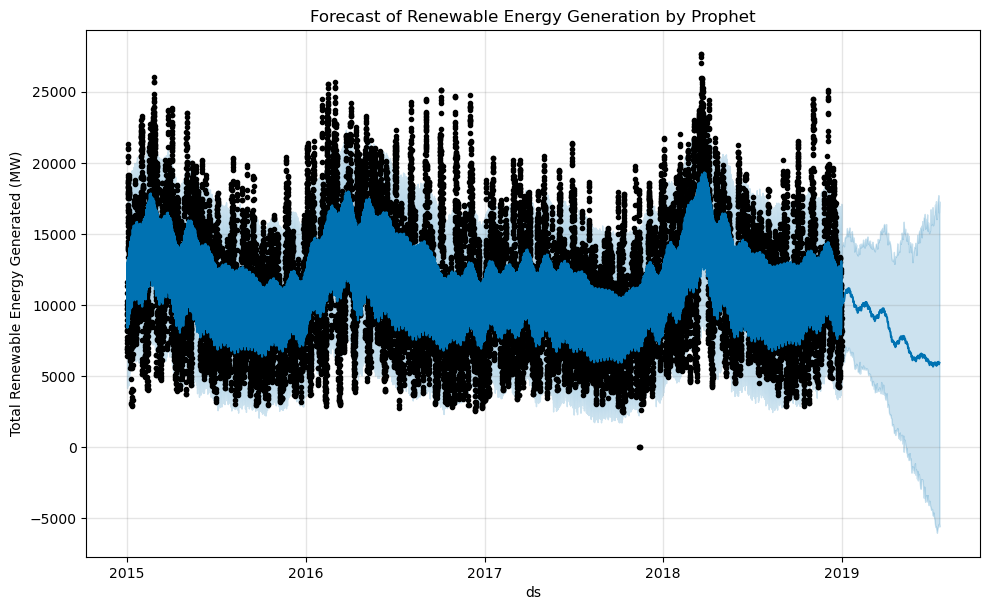

In [258]:
fig_best = best_model.plot(forecast_best)
plt.title('Forecast of Renewable Energy Generation by Prophet')
plt.ylabel("Total Renewable Energy Generated (MW)")
plt.show()

/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/Users/anastasiakurakova/miniconda3/envs/ml/lib/python3.11/site-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Serie

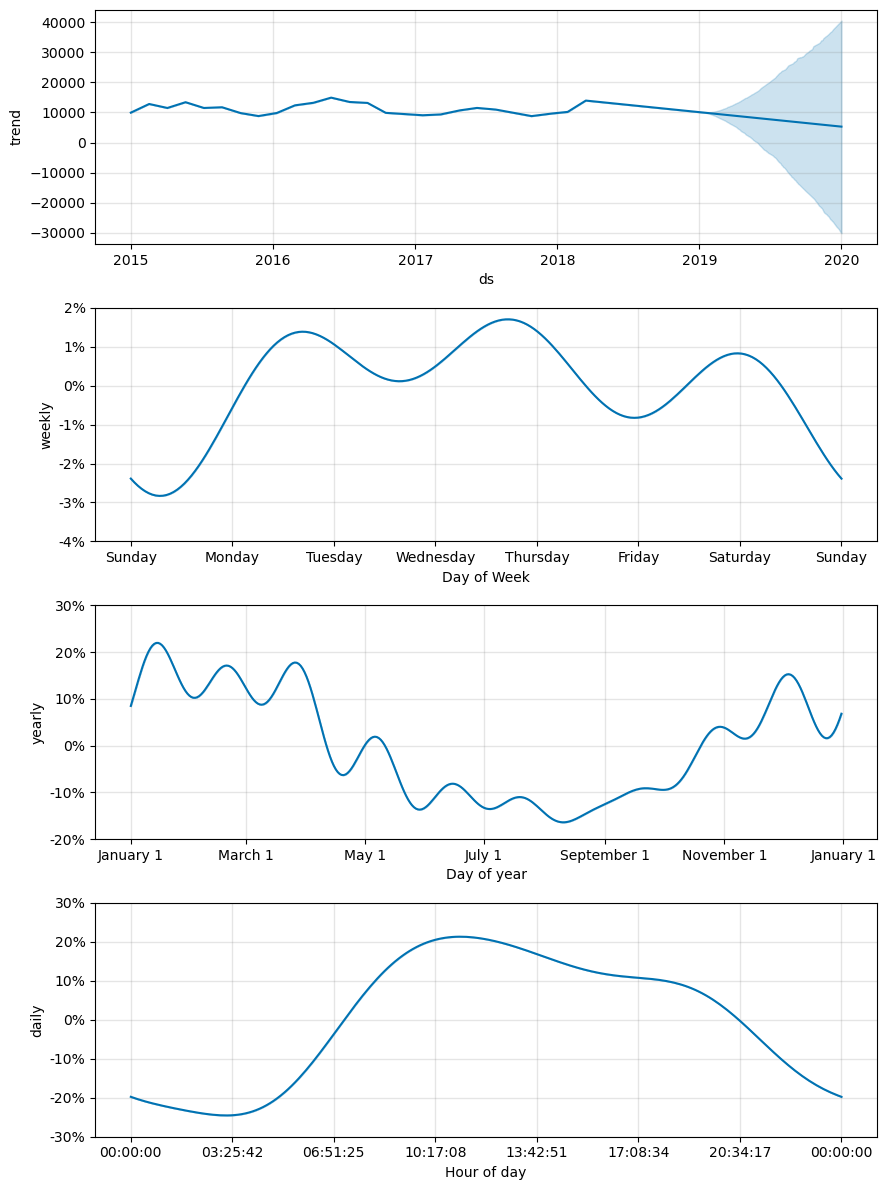

In [123]:
fig2_best = best_model.plot_components(forecast_best)

## The third model that we will try for the time series analysis is SARIMAX - seasonal ARIMA model

In [139]:
df_s = df[['time','total_renewable_energy']].copy()
df_s = df_s.set_index('time')

In [143]:
df_s = df_s.resample('D').mean()

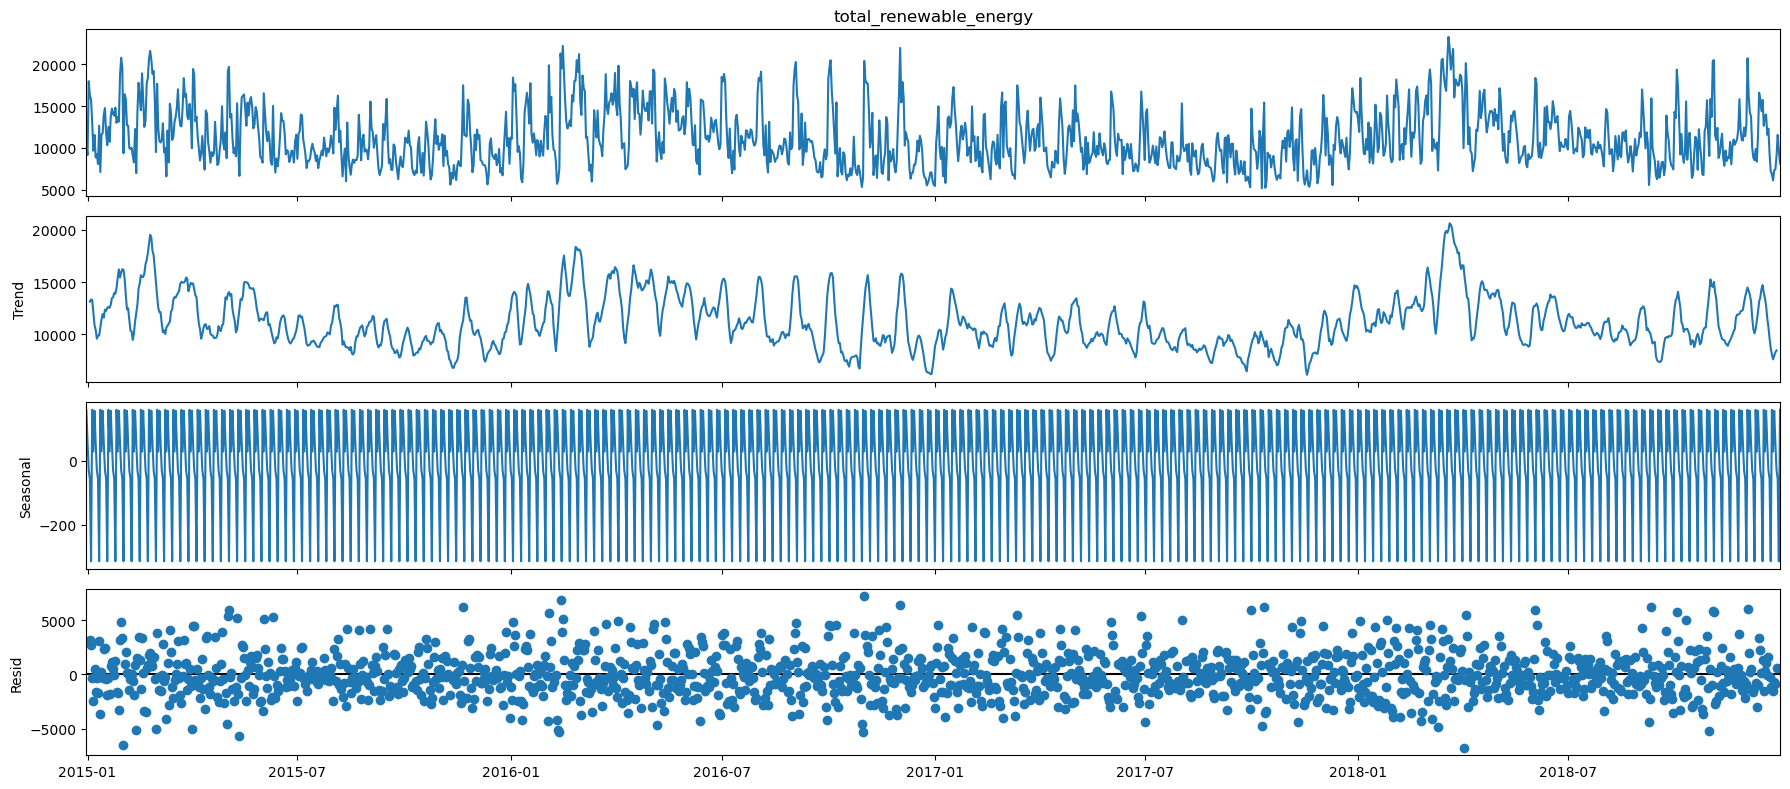

In [144]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_s['total_renewable_energy'], model='additive')
fig = decomposition.plot()
plt.show()

In [146]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


#### We are trying to determine an optimal parameters for p,d, and q in our SARIMAX model

In [148]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_s['total_renewable_energy'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit(disp=0)
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:31522.843054947945
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:30454.81061555032
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:28409.535656083433
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:27587.78892631948
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:28376.149063481906
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:27853.937763144426
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:27858.283296856724
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:27569.49354081139
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:30514.907251532928
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:28925.065229301174
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:27863.859339667306
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:27138.654915740277
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:27816.91753542897
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:29846.41621258595
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:27279.79324941476
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:26931.804629216975
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:27227.72207207408
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:26992.905690004765

In [149]:
mod = sm.tsa.statespace.SARIMAX(df_s['total_renewable_energy'],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit(disp=0)
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6110      0.046     13.213      0.000       0.520       0.702
ma.L1         -0.9713      0.015    -63.278      0.000      -1.001      -0.941
ar.S.L12      -0.0104      0.061     -0.171      0.864      -0.130       0.109
ma.S.L12      -0.9650      0.022    -44.769      0.000      -1.007      -0.923
sigma2      1.376e+07   5.12e-10   2.69e+16      0.000    1.38e+07    1.38e+07


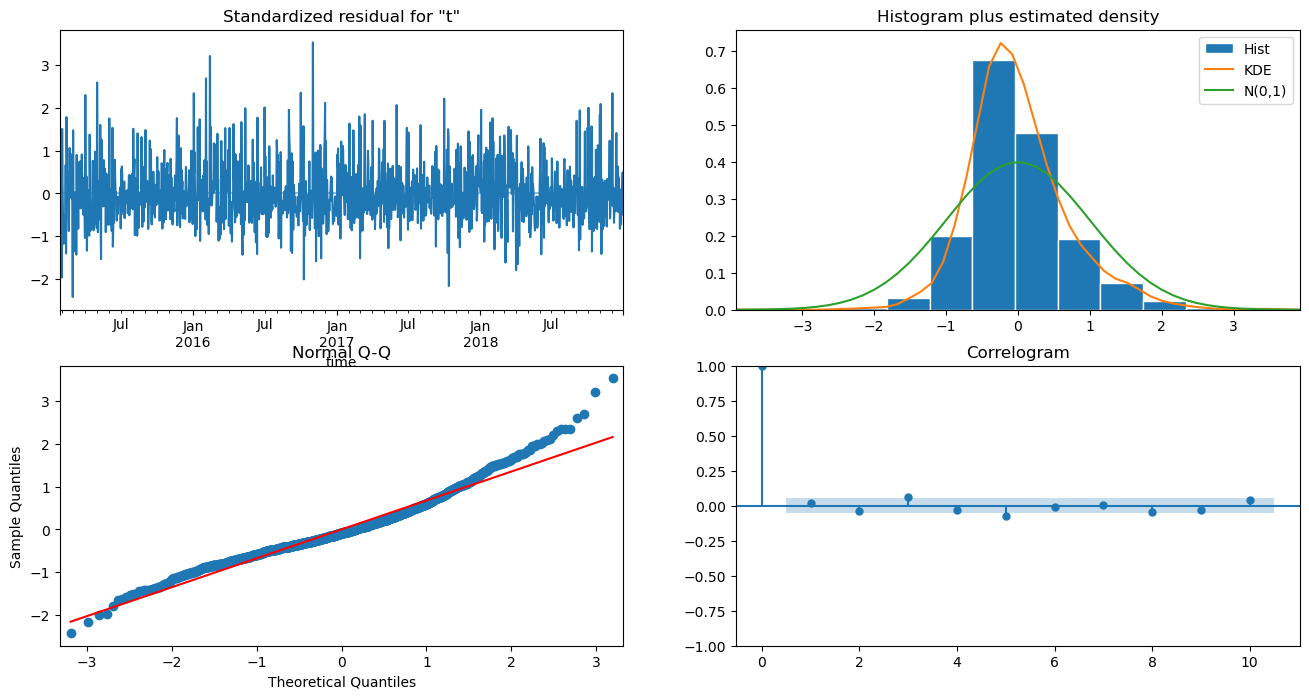

In [150]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

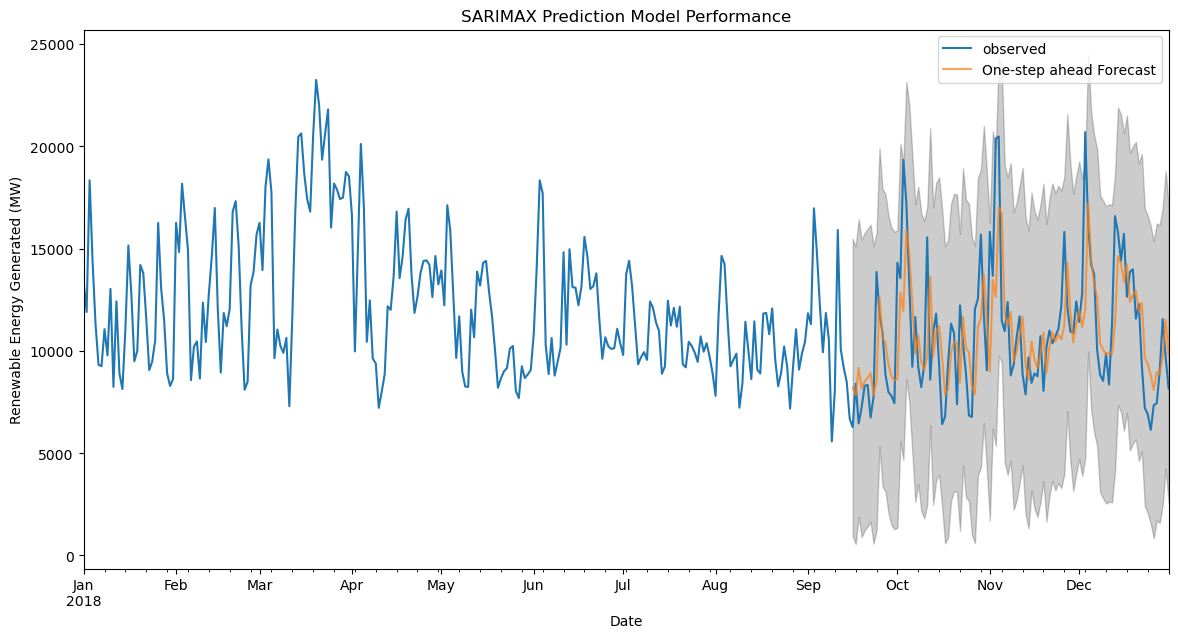

In [245]:

pred = results.get_prediction(start=pd.to_datetime('2018-09-16'), dynamic=False)
pred_ci = pred.conf_int()
ax = df_s['total_renewable_energy']['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_title('SARIMAX Prediction Model Performance')
ax.set_xlabel('Date')
ax.set_ylabel('Renewable Energy Generated (MW)')
plt.legend()
plt.show()

In [159]:
y_forecasted = pred.predicted_mean
y_truth = df_s['total_renewable_energy']['2018-09-16':]

In [160]:
# Evaluating model performance
rmse = np.sqrt(mean_squared_error(y_forecasted,y_truth))
mae = mean_absolute_error(y_forecasted,y_truth)
r2 = r2_score(y_forecasted,y_truth)
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2-score: {r2}')

RMSE: 2599.188724693361
MAE: 1928.657225197263
R2-score: -0.5501081532399161


In [165]:
# Using Mean Absolute Percentage Error.
def mean_absolute_percentage_error(y_true,y_pred):
    y_true, y_pred= np.array(y_true),np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100
mape = mean_absolute_percentage_error(y_forecasted,y_truth)
mape

18.089666170890176

#### We can observe that SARIMAX performed better than other 2 models based on the RMSE and MAE. However, its r-squared score is unsatisfactory. One possible explanation is oversimplification of the model, since we are trying to predict the amount of generated renewable energy purely based on historic data.

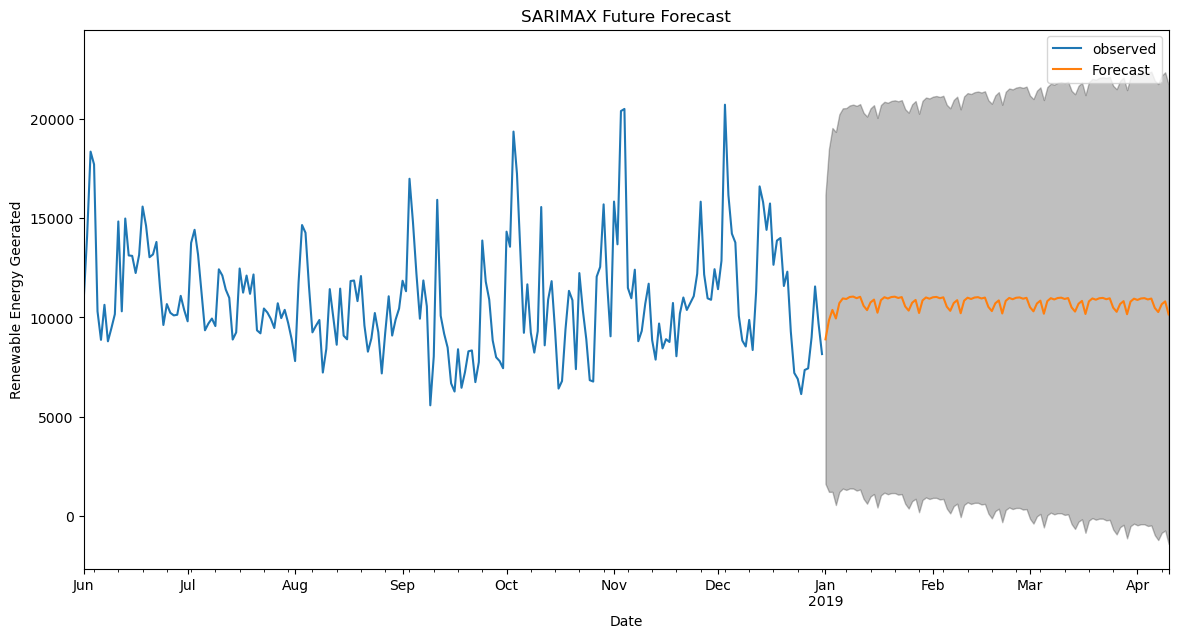

In [316]:
#Forecasting using SARIMAX
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = df_s['total_renewable_energy'].plot(label='observed', figsize=(14, 7))

pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Renewable Energy Geerated')
plt.legend()
ax.set_title('SARIMAX Future Forecast')
ax.set_xlim(pd.Timestamp('2018-06-01'))
plt.show()